**Analysis Code for the "Not So Simple Pendulum Experiment" (New January 2023, revised 10/2024)**


# **READ ME: General Comments**

**Using me as a jupyter notebook is recommended, spyder should work as well**

This new (and hopefully improved) version of the analysis code will allow you to analyse your recordings of the pendulum. It will allow you to modify the length of the video as well as to crop the individual frames of it. The functions provided will give you lists containing the average x- and y- positions of the pendulum in every frame. From this point on, you will have to continue analysing the data yourself.

There are two functions in this code:

* Video Analysis
* mean_white_pixel_position

The first reads your video frame-by-frame, crops it according to your specifications and converts it to greyscale. Then it will **turn each frame into a black-and-white image**. Any pixel which exceeds a threshold value of brightness will be set to white, all others to black. This means the swinging pendulum in front of a dark background should appear as a white blob. *VideoAnalysis* will return a *numpy array* containing the black-and white frames. This can be handed to the second function which will calculate the mean x- and y- positions of all white pixels in each frame. The function will return two lists, one containing the average white pixel x-position for each frame, the other the corresponding mean y-positions. 

**Note: You do not need to read the code in the first cell** (unless you want to). The following analysis cells are commented and should suffice to guide you through the analysis. However, in case you encounter any problems with the code, the comments in the function definitions might be helpful.



**Installing the opvencv package**

Apart from numpy and matplotlib, the code uses one further package. Unfortuantely, *opencv-python* is not part of the basic Anaconda installation which many of you may use. You will probably have to install them manually. You can do this by copying

import sys

!{sys.executable} -m pip install opencv-python

into a new cell of a jupyter notebook and running it. 

It should however be installed on all of the machines in the Y1 lab.

In [12]:
#Run me if the opencv-python package is not installed yet.
import sys

!{sys.executable} -m pip install opencv-python

In [1]:
# This cell only contains function definitions, you can jump to the next one
from scipy.optimize import curve_fit
import cv2
import numpy as np
import matplotlib.pyplot as plt

def VideoAnalysis(video_path, crop_region=None, start_frame=0, end_frame=None,threshold = 150):
    """
    This function will load the .mp4 video recorded of the bob, shorten its length according to the parameters specified and crop it
    according to the specified parameters. Then, it will turn every pixel of every frame into gray-scale and subsequently every frame
    into a black-and white image. Any pixel with a brightnes larger than the specified threshold will be set white, all others will be
    set black.
    The function will open a window displaying the processed video frame-by-frame in realtime.
    
    Parameters:
        - video_path:       STRING Path of the video to by processed 
        - crop_region:      TUPLE containing x, y, width, height; 
        - start_frame:      INT Number of the first frame to be processed
        - end_frame:        INT Number of the last frame to be processed
        - threshold:        INT The threshold for which the 
        
    Returns:
        A numpy array of dimension "end_frame - start_frame" X "width" X "height" containing black-and-white pixels for each frame.
        The bob should be visible as a white object while the background should be black.
    """
    
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    # This checks if the video is open, returns an error message if not.
    if not cap.isOpened():
        print("Error: Could not open video.")
        return None

    # Set the starting and ending frames
    # cv2.CAP_PROP_POS_FRAMES is the number of the frame to be decoded next. Every time the read() function is used on the
    # cap object, this will be incremented by 1. The following line will set it to a non-zero value in case we do not want to
    # start decoding the video from the start
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    # If end_frame is not provided, set it to the last frame
    # cv2.CAP_PROP_FRAME_COUNT is the number of frames in the whole video
    if end_frame is None:
        end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Get video properties and print them
    # opencv allows to read out many properties of a given video individually as already seen above in the code. 
    # This part of the function will retrieve the most important ones and print them. 
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    print("Video Properties \nFrame Width Frame Height, FPS: ")
    print(frame_width,frame_height,fps)

    # Define the crop region using the crop_region parameter of the function (x, y, width, height)
    # If it is not  set, the whole image will be used
    if crop_region == None:
        x, y, w, h = 0, 0, -1, -1
    else: 
        x, y, w, h = crop_region

    # Create an array to store black and white images
    bw_images = []

    while True:
        # Read a frame from the video, the VideoCapture.read() function also conveniently outputs a boolean "ret"
        # Which is True if the frame was read correctly. This can be used to check if all the frames were read.
        
        ret, frame = cap.read()

        if not ret or cap.get(cv2.CAP_PROP_POS_FRAMES) >= end_frame:
            break  # Break the loop if no more frames or reached the end_frame

        # Crop the frame
        cropped_frame = frame[y:y + h, x:x + w]

        # Convert the cropped frame to grayscale
        # This cv2 built-in function takes a frame as the first argument the second is there to specify how
        # the color is supposed to be converted from RGB to Grayscale in our case
        gray_frame = cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2GRAY)
        
        # Apply the threshold to create a binary black and white image
        # The last parameter specifies the way the threshold is applied
        # In our case: all pixels with brightness above threshold will be set to 255, all other to 0
        
        _, bw_frame = cv2.threshold(gray_frame, threshold, 255, cv2.THRESH_BINARY)

        # Append the black and white frame to the list
        bw_images.append(bw_frame)
        
        # Display the frame
        cv2.imshow('Cropped and Black and White Frame', bw_frame)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(int(1000 / fps)) & 0xFF == ord('q'):
            break

    # Release the video capture object and close windows
    cap.release()
    cv2.destroyAllWindows()

    # Convert the list of black and white frames to a NumPy array
    bw_images_array = np.array(bw_images)

    return bw_images_array

def mean_white_pixel_position(bw_images_array):
    """
    Calculate the mean position of all white pixels in each frame of a binary black and white video.

    Parameters:
    - bw_images_array: NumPy array representing a sequence of binary black and white frames.

    Returns:
    - Two lists, the first one contains the mean x position of all white pixels for each frame and the second the mean y position.
    """
    mean_x = []
    mean_y = []

    for frame in bw_images_array:
        # Find the coordinates of white pixels
        # This line is somewhat weird at first glance. The function np.where() will return two lists for a 2D array. The function
        # parses the array - in this case the frame - row by row and will record the x-index of every frame in which an element with value 255
        # was found in the second list. This means for example, if 5 Pixels have an x-position of "0" and another one has an x-position of 
        # "8", the function will return a list which contains [0,0,0,0,0,8]. The exact order of the number depends on the row the number
        # occurrs in and the way the function reads through the array.
        # It does the same for the y-position in the first list. It will parse the array column by column, though.  
        white_pixels = np.where(frame == 255)

        # Calculate the mean position
        # Because we have a list which contains the pixel indeces as values as many times as they occurred, we simply have to calculate
        # the mean of the corresponding list to get the mean position of the white pixel.
        mean_xtemp = int(np.mean(white_pixels[1])) if white_pixels[1].size > 0 else 0
        mean_ytemp = int(np.mean(white_pixels[0])) if white_pixels[0].size > 0 else 0

        # Append the mean position to the list
        mean_x.append(mean_xtemp)
        mean_y.append(mean_ytemp)

    return mean_x, mean_y

In [93]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def Analysis(file_name, p0, crop_region, start_time=None, end_time=None):
    

    # Video path
    video_path = (r"/Users/michael/Library/CloudStorage/OneDrive-ImperialCollegeLondon/"
                  "Lab/pendulum/videos/" + file_name)

    
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    cap.release()

    
    bw_array = VideoAnalysis(video_path, crop_region, 0, None, threshold=165)
    total_frames = len(bw_array)

   
    if start_time is not None:
        start_frame = int(start_time * fps)
    else:
        start_frame = 0

    if end_time is not None:
        end_frame = int(end_time * fps)
    else:
        end_frame = total_frames

    
    bw_array = bw_array[start_frame:end_frame]
    x, y = mean_white_pixel_position(bw_array)
    x = np.array(x)
    length = len(bw_array)
    time = np.arange(length) / fps

    
    def func(t, a, b, c, d):
        return a * np.sin(b * t + c) + d

    
    popt, pcov = curve_fit(func, time, x, p0)

    
    plt.plot(time, x, label="data")
    plt.plot(time, func(time, *popt), label="fit")
    plt.xlabel("time (s)")
    plt.ylabel("x displacement (pixels)")
    plt.legend()
    plt.show()

    return popt[1], np.sqrt(pcov[1, 1]) 

    




Video Properties 
Frame Width Frame Height, FPS: 
1280 720 24.08541817449244


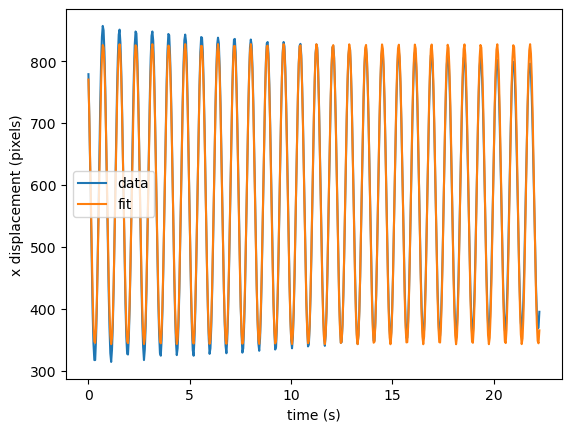

Video Properties 
Frame Width Frame Height, FPS: 
1280 720 15.086854507606484


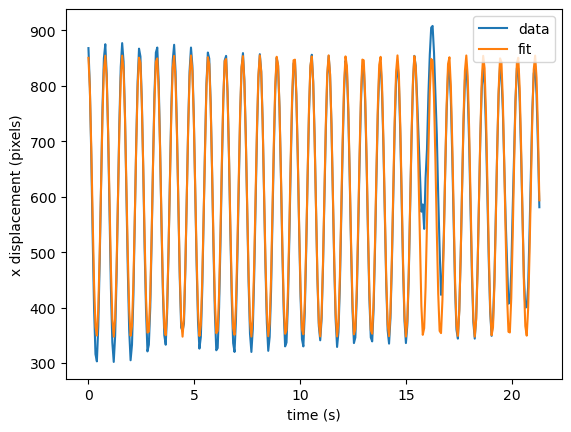

Video Properties 
Frame Width Frame Height, FPS: 
1280 720 15.090137472101436


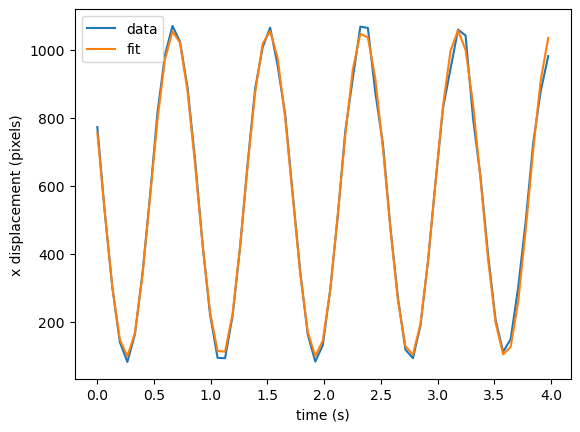

In [94]:
rad = np.pi/180

w20, sig20 = Analysis("20degT.mp4", p0=[250, 7.54, 580, 600], crop_region=(0, 0, 1200, 550))
w30, sig30 = Analysis("30degT.mp4", p0=[250, 7.54, 0, 600], crop_region=(0, 0, 1200, 550))
w60, sig60 = Analysis("60degT.mp4", p0=[250, 7.55, 580, 600], crop_region=(0, 0, 1200, 522),
                      start_time=10, end_time=14)

ang_freq_list = np.array([w20, w30, w60])
sigma_omega_list = np.array([sig20, sig30, sig60])

T_list = 2*np.pi / ang_freq_list
sigma_T_list = 2*np.pi * sigma_omega_list / (ang_freq_list**2)


Amplitude_list = np.array([20*rad, 30*rad, 60*rad])




      


[0.81050011 0.81132107 0.83487936]


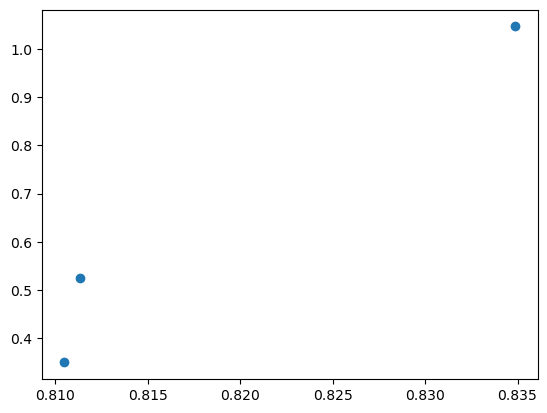

In [95]:
print(T_list)
Amplitude_list = np.array([20*rad, 30*rad, 60*rad])
plt.scatter(T_list, Amplitude_list)




/var/folders/x9/9_sl4qsx17j1d893yk0m7gxm0000gn/T/ipykernel_4310/457672757.py:4: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(final_func, Amplitude_list, T_list, p0=[11.5, 0, 0])


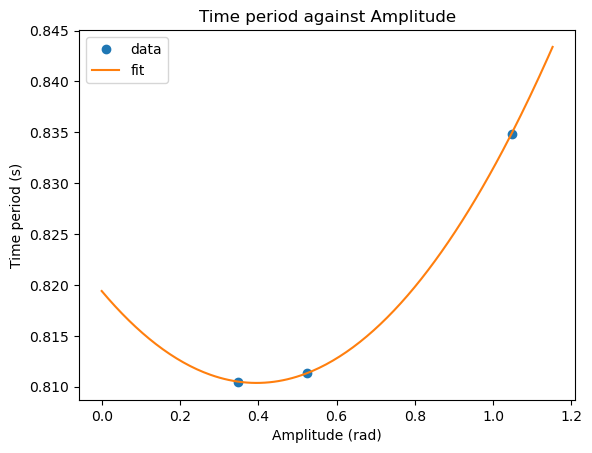

array([ 0.81940589, -0.05572064,  0.07042921])

In [133]:
def final_func(theta, T_0, a, b):
    return T_0 * (1 + a*theta + b*theta**2)

popt, pcov = curve_fit(final_func, Amplitude_list, T_list, p0=[11.5, 0, 0])

theta_plot = np.linspace(0, max(Amplitude_list)*1.1, 200)
T_fit = final_func(theta_plot, *popt)

plt.plot(Amplitude_list, T_list, 'o', label='data')
plt.plot(theta_plot, T_fit, label='fit')
plt.title("Time period against Amplitude")
plt.xlabel("Amplitude (rad)")
plt.ylabel("Time period (s)")
plt.legend()
plt.show()

popt








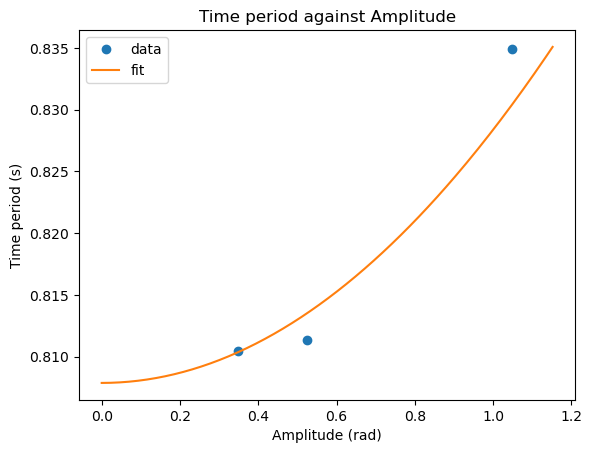

[0.80787513 0.02538134]
[[ 1.00304143e-08 -6.95388796e-08]
 [-6.95388796e-08  6.32899728e-07]]


In [130]:
def func(theta, T_0, b):
    return T_0 * (1 + b*theta**2)

popt, pcov = curve_fit(func, Amplitude_list, T_list, p0=[11.5, 0], sigma = sigma_T_list, absolute_sigma=True)

theta_plot = np.linspace(0, max(Amplitude_list)*1.1, 200)
T_fit = func(theta_plot, *popt)

plt.title("Time period against Amplitude")
plt.xlabel("Amplitude (rad)")
plt.ylabel("Time period (s)")
plt.plot(Amplitude_list, T_list, 'o', label='data')
plt.plot(theta_plot, T_fit, label='fit')
plt.legend()
plt.show()
print(popt)
print(pcov

Video Properties 
Frame Width Frame Height, FPS: 
1280 720 24.08541817449244


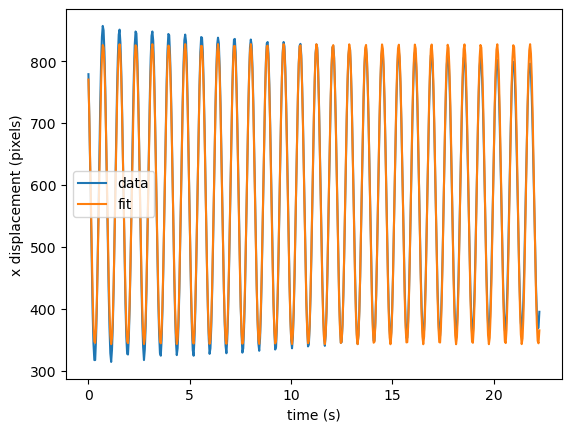

(np.float64(7.752232509472544), np.float64(0.0004862859810405313))

In [134]:
Analysis("20degT.mp4", p0=[250, 7.54, 580, 600], crop_region=(0, 0, 1200, 550))